### IMPORTING LIBRARIES

In [1]:
# !pip install geopy
# !pip install folium
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from scipy.stats import zscore

### Load the main dataset and the dataset with lat/lon information

In [2]:
main_df = pd.read_csv('DELTA_crosschecked.csv')
lat_lon_df = pd.read_csv('polling-units.csv')

# Merge the datasets on the common column (Ward)
df = pd.merge(main_df, lat_lon_df, on='Ward')

# check the first 5 rows of the data 
print(df.head())

  State_x            LGA   Ward       PU-Code  \
0   DELTA  ANIOCHA NORTH  OBIOR  10-01-01-001   
1   DELTA  ANIOCHA NORTH  OBIOR  10-01-01-001   
2   DELTA  ANIOCHA NORTH  OBIOR  10-01-01-001   
3   DELTA  ANIOCHA NORTH  OBIOR  10-01-01-001   
4   DELTA  ANIOCHA NORTH  OBIOR  10-01-01-001   

                                        PU-Name_x  Accredited_Voters  \
0  KANIDILIMA P/S - ISHIEKPE QUARTERS, ONICHA-UKU                213   
1  KANIDILIMA P/S - ISHIEKPE QUARTERS, ONICHA-UKU                213   
2  KANIDILIMA P/S - ISHIEKPE QUARTERS, ONICHA-UKU                213   
3  KANIDILIMA P/S - ISHIEKPE QUARTERS, ONICHA-UKU                213   
4  KANIDILIMA P/S - ISHIEKPE QUARTERS, ONICHA-UKU                213   

   Registered_Voters  Results_Found  Transcription_Count  \
0               1990           True                   -1   
1               1990           True                   -1   
2               1990           True                   -1   
3               1990           T

In [3]:
# Check the merging result
print("Merged DataFrame shape:", df.shape)
print(df.head())

Merged DataFrame shape: (110310, 24)
  State_x            LGA   Ward       PU-Code  \
0   DELTA  ANIOCHA NORTH  OBIOR  10-01-01-001   
1   DELTA  ANIOCHA NORTH  OBIOR  10-01-01-001   
2   DELTA  ANIOCHA NORTH  OBIOR  10-01-01-001   
3   DELTA  ANIOCHA NORTH  OBIOR  10-01-01-001   
4   DELTA  ANIOCHA NORTH  OBIOR  10-01-01-001   

                                        PU-Name_x  Accredited_Voters  \
0  KANIDILIMA P/S - ISHIEKPE QUARTERS, ONICHA-UKU                213   
1  KANIDILIMA P/S - ISHIEKPE QUARTERS, ONICHA-UKU                213   
2  KANIDILIMA P/S - ISHIEKPE QUARTERS, ONICHA-UKU                213   
3  KANIDILIMA P/S - ISHIEKPE QUARTERS, ONICHA-UKU                213   
4  KANIDILIMA P/S - ISHIEKPE QUARTERS, ONICHA-UKU                213   

   Registered_Voters  Results_Found  Transcription_Count  \
0               1990           True                   -1   
1               1990           True                   -1   
2               1990           True                   -

In [4]:
# Check for missing values in 'latitude' and 'longitude' columns
print(df[['Latitude', 'Longitude']].isnull().sum())

Latitude     23497
Longitude    23497
dtype: int64


In [5]:
# Check for missing values in 'latitude' and 'longitude' columns after merging
if 'Latitude' in df.columns and 'Longitude' in df.columns:
    print("Missing values in 'latitude' and 'longitude' columns after merging:\n", df[['Latitude', 'Longitude']].isnull().sum())
else:
    print("'latitude' and/or 'longitude' columns are not in the merged DataFrame.")

Missing values in 'latitude' and 'longitude' columns after merging:
 Latitude     23497
Longitude    23497
dtype: int64


### Drop NaN Values

In [6]:
# Drop rows with missing values in 'latitude' and 'longitude' columns
df = df.dropna(subset=['Latitude', 'Longitude'])

# Ensure DataFrame is not empty after dropping missing values
if df.empty:
    raise ValueError("DataFrame is empty after handling missing values. Check the merging process and data integrity.")

# Convert latitudes and longitudes to radians

In [7]:
df['latitude_radians'] = np.radians(df['Latitude'])
df['longitude_radians'] = np.radians(df['Longitude'])

### Calculate pairwise distances and identify neighbors

In [14]:
from sklearn.neighbors import NearestNeighbors


# Extract coordinates
coords = df[['latitude_radians', 'longitude_radians']].values

# Initialize NearestNeighbors model
radius = 1 / 6371  # Convert km to radians (approximation)
nn = NearestNeighbors(radius=radius, metric='haversine')

# Fit the model
nn.fit(coords)

# Find neighbors within the radius
distances, indices = nn.radius_neighbors(coords)

# Create a dictionary of neighbors
neighbors = {i: indices[i] for i in range(len(indices))}

# Display the neighbors
print(neighbors)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [9]:
from sklearn.metrics.pairwise import haversine_distances
# coords = df[['latitude_radians', 'longitude_radians']].values
# if coords.size == 0:
#     raise ValueError("Coordinates array is empty. Check your data and merging process.")

# dist_matrix = haversine_distances(coords) * 6371  # Convert to kilometers

# # Define a radius (1 km)
# radius = 1

# # Identify neighbors within the radius
# neighbors = {i: np.where(dist_matrix[i] <= radius)[0] for i in range(len(df))}

MemoryError: Unable to allocate 56.2 GiB for an array with shape (86813, 86813) and data type float64

# Calculate outlier scores

In [15]:
def calculate_outlier_scores(neighbors, df, id_column):
    outlier_scores = []
    for i, neighbor_indices in neighbors.items():
        if len(neighbor_indices) > 1:
            for party in ['APC', 'LP', 'PDP', 'NNPP']:
                votes = df.iloc[neighbor_indices][party].values
                z_scores = zscore(votes)
                outlier_scores.append({
                    id_column: df.iloc[i][id_column],
                    'party': party,
                    'outlier_score': z_scores[np.where(neighbor_indices == i)[0][0]]
                })
    return pd.DataFrame(outlier_scores)

# Determine the appropriate identifier column
id_column = 'unit_id' if 'unit_id' in df.columns else df.columns[4]

# Calculate outlier scores
outlier_scores = calculate_outlier_scores(neighbors, df, id_column)
print(outlier_scores.head())

KeyboardInterrupt: 

In [122]:
# Define a function to calculate the outlier score
def calculate_outlier_score(votes, neighbor_votes):
    return abs(votes - np.mean(neighbor_votes))

# Sample DataFrame
data = {
    'PU-Name': ['PU1', 'PU2', 'PU3', 'PU4'],
    'latitude': [6.5244, 6.5245, 6.5246, 6.5247],
    'longitude': [3.3792, 3.3793, 3.3794, 3.3795],
    'APC': [100, 150, 120, 130],
    'LP': [200, 180, 210, 220],
    'PDP': [300, 280, 290, 310],
    'NNPP': [50, 60, 55, 65]
}
df = pd.DataFrame(data)

# Define a radius (in km)
radius = 1

# Initialize outlier score columns
df['APC_outlier_score'] = 0.0
df['LP_outlier_score'] = 0.0
df['PDP_outlier_score'] = 0.0
df['NNPP_outlier_score'] = 0.0

# Calculate outlier scores for each polling unit
for i, row in df.iterrows():
    # Get the coordinates of the current polling unit
    current_coords = (row['latitude'], row['longitude'])
    
    # Find neighboring polling units
    neighbors = []
    for j, neighbor_row in df.iterrows():
        if i != j:
            neighbor_coords = (neighbor_row['latitude'], neighbor_row['longitude'])
            distance = geodesic(current_coords, neighbor_coords).kilometers
            if distance <= radius:
                neighbors.append(neighbor_row)
    
    if neighbors:
        # Calculate outlier scores for each party
        neighbors_df = pd.DataFrame(neighbors)
        df.at[i, 'APC_outlier_score'] = calculate_outlier_score(row['APC'], neighbors_df['APC'])
        df.at[i, 'LP_outlier_score'] = calculate_outlier_score(row['LP'], neighbors_df['LP'])
        df.at[i, 'PDP_outlier_score'] = calculate_outlier_score(row['PDP'], neighbors_df['PDP'])
        df.at[i, 'NNPP_outlier_score'] = calculate_outlier_score(row['NNPP'], neighbors_df['NNPP'])

print(df)

  PU-Name  latitude  longitude  APC   LP  PDP  NNPP  APC_outlier_score  \
0     PU1    6.5244     3.3792  100  200  300    50          33.333333   
1     PU2    6.5245     3.3793  150  180  280    60          33.333333   
2     PU3    6.5246     3.3794  120  210  290    55           6.666667   
3     PU4    6.5247     3.3795  130  220  310    65           6.666667   

   LP_outlier_score  PDP_outlier_score  NNPP_outlier_score  
0          3.333333           6.666667           10.000000  
1         30.000000          20.000000            3.333333  
2         10.000000           6.666667            3.333333  
3         23.333333          20.000000           10.000000  


### Save the cleaned dataset to a CSV file

In [119]:
cleaned_dataset_filename = 'gina_cleaned_delta_election_data_with_outlier_scores.csv'
df.to_csv(cleaned_dataset_filename, index=False)

print(f"Cleaned dataset saved to {cleaned_dataset_filename}")

Cleaned dataset saved to gina_cleaned_delta_election_data_with_outlier_scores.csv


## Visualization

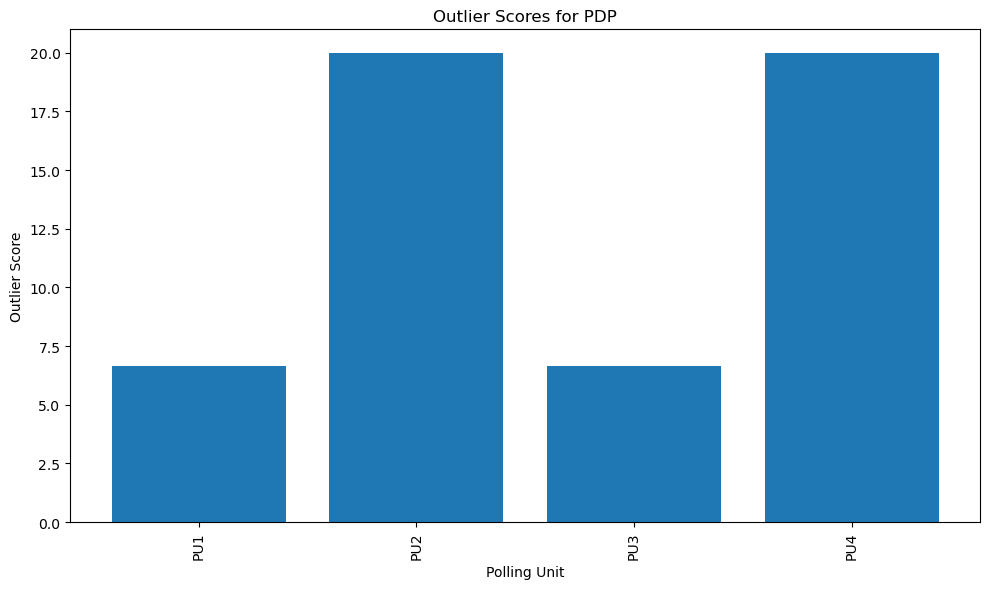

In [123]:
# Plotting the bar chart for PDP outlier scores
plt.figure(figsize=(10, 6))
plt.bar(df['PU-Name'], df['PDP_outlier_score'])
plt.xticks(rotation=90)
plt.xlabel('Polling Unit')
plt.ylabel('Outlier Score')
plt.title('Outlier Scores for PDP')
plt.tight_layout()
plt.show()


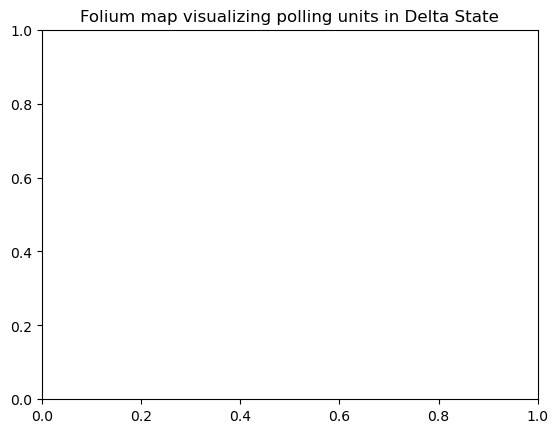

In [125]:
import folium

# Create a folium map to visualize polling units
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=12)


# Add markers for each polling unit
for index, row in df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Polling Unit: {row['PU-Name']}\nAPC Outlier Score: {row['APC_outlier_score']}\nLP Outlier Score: {row['LP_outlier_score']}\nPDP Outlier Score: {row['PDP_outlier_score']}\nNNPP Outlier Score: {row['NNPP_outlier_score']}"
    ).add_to(m)
plt.title('Folium map visualizing polling units in Delta State')
# Save the map as an HTML file
m.save('polling_units_map.html')

# Display the map (this will work in Jupyter notebooks)
m

In [118]:
# Save the map as an HTML file
m.save('polling_units_map.html')

# Sort the dataset by outlier scores

In [81]:
sorted_outliers = outlier_scores.sort_values(by='outlier_score', ascending=False)
sorted_outliers.to_csv('sorted_outlier_scores.csv', index=False)
print(sorted_outliers.head())

                                      PU-Name party  outlier_score
19  ATUMA IGA PRIMARY SCHOOL - OGBE-ANI/AJAJI  NNPP       2.899692
7   ATUMA IGA PRIMARY SCHOOL - OGBE-ANI/AJAJI  NNPP       2.899692
15  ATUMA IGA PRIMARY SCHOOL - OGBE-ANI/AJAJI  NNPP       2.899692
11  ATUMA IGA PRIMARY SCHOOL - OGBE-ANI/AJAJI  NNPP       2.899692
23  ATUMA IGA PRIMARY SCHOOL - OGBE-ANI/AJAJI  NNPP       2.899692


# Identify top 3 outliers for each party

In [84]:
top_outliers = sorted_outliers.groupby('party').head(3)
print(top_outliers)

                                               PU-Name party  outlier_score
19           ATUMA IGA PRIMARY SCHOOL - OGBE-ANI/AJAJI  NNPP       2.899692
7            ATUMA IGA PRIMARY SCHOOL - OGBE-ANI/AJAJI  NNPP       2.899692
15           ATUMA IGA PRIMARY SCHOOL - OGBE-ANI/AJAJI  NNPP       2.899692
153  AGBOGIDI PRIMARY SCHOOL-OGBE ONISHE/OGBE ANI/O...    LP       2.686157
149  AGBOGIDI PRIMARY SCHOOL-OGBE ONISHE/OGBE ANI/O...    LP       2.686157
165  AGBOGIDI PRIMARY SCHOOL-OGBE ONISHE/OGBE ANI/O...    LP       2.686157
788          EZI-EKE OGBE-OKODE UMU-EKEKE (OPEN SPACE)   APC       2.571024
812          EZI-EKE OGBE-OKODE UMU-EKEKE (OPEN SPACE)   APC       2.571024
808          EZI-EKE OGBE-OKODE UMU-EKEKE (OPEN SPACE)   APC       2.571024
14           ATUMA IGA PRIMARY SCHOOL - OGBE-ANI/AJAJI   PDP       2.400337
6            ATUMA IGA PRIMARY SCHOOL - OGBE-ANI/AJAJI   PDP       2.400337
10           ATUMA IGA PRIMARY SCHOOL - OGBE-ANI/AJAJI   PDP       2.400337


In [85]:
# Explain why they are outliers
for index, row in top_outliers.iterrows():
    identifier = row[id_column]
    party = row['party']
    score = row['outlier_score']
    print(f"Unit {identifier} is an outlier for {party} with an outlier score of {score}.")

Unit ATUMA IGA PRIMARY SCHOOL - OGBE-ANI/AJAJI is an outlier for NNPP with an outlier score of 2.8996918043796436.
Unit ATUMA IGA PRIMARY SCHOOL - OGBE-ANI/AJAJI is an outlier for NNPP with an outlier score of 2.8996918043796436.
Unit ATUMA IGA PRIMARY SCHOOL - OGBE-ANI/AJAJI is an outlier for NNPP with an outlier score of 2.8996918043796436.
Unit AGBOGIDI PRIMARY SCHOOL-OGBE ONISHE/OGBE ANI/OGBE IYASE is an outlier for LP with an outlier score of 2.6861574456825354.
Unit AGBOGIDI PRIMARY SCHOOL-OGBE ONISHE/OGBE ANI/OGBE IYASE is an outlier for LP with an outlier score of 2.6861574456825354.
Unit AGBOGIDI PRIMARY SCHOOL-OGBE ONISHE/OGBE ANI/OGBE IYASE is an outlier for LP with an outlier score of 2.6861574456825354.
Unit EZI-EKE OGBE-OKODE UMU-EKEKE (OPEN SPACE) is an outlier for APC with an outlier score of 2.571023850942569.
Unit EZI-EKE OGBE-OKODE UMU-EKEKE (OPEN SPACE) is an outlier for APC with an outlier score of 2.571023850942569.
Unit EZI-EKE OGBE-OKODE UMU-EKEKE (OPEN SPACE) i

In [87]:
# Save sorted outlier scores to a CSV file
sorted_outliers.to_csv('sorted_outlier_scores.csv', index=False)

In [88]:
# Identify top 3 outliers for each party
top_outliers = sorted_outliers.groupby('party').head(3)

# Save top outliers to a CSV file
top_outliers.to_csv('top_outliers.csv', index=False)

In [89]:
# Save the full dataset with calculated columns
df.to_csv('full_dataset_with_calculations.csv', index=False)

In [90]:
# Print statements to confirm saving
print("Sorted outlier scores saved to 'sorted_outlier_scores.csv'")
print("Top 3 outliers for each party saved to 'top_outliers.csv'")
print("Full dataset with calculations saved to 'full_dataset_with_calculations.csv'")

Sorted outlier scores saved to 'sorted_outlier_scores.csv'
Top 3 outliers for each party saved to 'top_outliers.csv'
Full dataset with calculations saved to 'full_dataset_with_calculations.csv'
